# Cross-Entropy Method (CEM) Planner

> Planner using the Cross-Entropy Method (CEM) for optimization of discrete action sequences.

In [ ]:
# | default_exp planners.cem_planner

In [ ]:
# #| hide
# from nbdev.showdoc import *  

In [ ]:
# #| export 
# from fastcore.utils import *
# import pandas as pd
# import wandb
# import os
# from mawm.data.utils import base_tf, msg_tf
# import numpy as np

In [ ]:
# #| export

# import torch
# import torch.nn.functional as F
# import numpy as np
# from einops import rearrange, repeat

# class DiscreteCEMPlanner():
#     def __init__(
#         self,
#         horizon,
#         topk,
#         num_samples,
#         opt_steps,
#         eval_every,
#         wm,
#         action_dim, # This is now the number of discrete actions
#         objective_fn,
#         preprocessor,
#         evaluator,
#         wandb_run,
#         smoothing=0.01, # Laplace smoothing constant
#         logging_prefix="plan_discrete",
#         log_filename="logs.json",
#         **kwargs,
#     ):
#         super().__init__(
#             wm, action_dim, objective_fn, preprocessor, 
#             evaluator, wandb_run, log_filename
#         )
#         self.horizon = horizon
#         self.topk = topk
#         self.num_samples = num_samples
#         self.opt_steps = opt_steps
#         self.eval_every = eval_every
#         self.smoothing = smoothing
#         self.logging_prefix = logging_prefix

#     def init_probs(self, obs_0):
#         """Initializes a uniform distribution over actions for each timestep."""
#         n_evals = obs_0["visual"].shape[0]
#         # (Batch, Horizon, Num_Actions) - start with uniform probabilities
#         probs = torch.full((n_evals, self.horizon, self.action_dim), 1.0 / self.action_dim)
#         return probs

    

In [ ]:
# #| export
# @patch
# def plan(self: DiscreteCEMPlanner, obs_0, obs_g, actions=None):
#     trans_obs_0 = self.preprocessor(obs_0).to(self.device)
#     trans_obs_g = self.preprocessor(obs_g).to(self.device)
    
#     z_obs_g = self.wm.backbone(trans_obs_g)
#     z_obs_g = {f"goal_agent{i}": v for i, v in enumerate(z_obs_g)}
    
#     trans_obs_0 = {f"agent{i}": v for i, v in enumerate(trans_obs_0)}

#     msgs = {agent: msg_tf((obs_0[agent]['pov'], agent, False)) for agent in self.agents}

#     # Initialize probabilities
#     probs = self.init_probs(obs_0).to(self.device)
#     n_evals = probs.shape[0]

#     for i in range(self.opt_steps):
#         losses = []
#         for traj_idx in range(n_evals):
#             # 1. Prepare observations for the current trajectory batch
#             cur_trans_obs_0 = {
#                 key: repeat(arr[traj_idx].unsqueeze(0), "1 ... -> n ...", n=self.num_samples)
#                 for key, arr in trans_obs_0.items()
#             }
#             cur_z_obs_g = {
#                 key: repeat(arr[traj_idx].unsqueeze(0), "1 ... -> n ...", n=self.num_samples)
#                 for key, arr in z_obs_g.items()
#             }

#             # 2. Sample discrete actions from the current distribution
#             # We flatten to sample, then reshape back
#             p = probs[traj_idx] # (H, action_dim)
#             # Sample (num_samples) for each step in the horizon
#             sampled_indices = torch.multinomial(p, self.num_samples, replacement=True) 
#             sampled_indices = sampled_indices.T # (num_samples, H)

#             # 3. Rollout in World Model
#             # Note: If your WM expects one-hot, convert sampled_indices here
#             with torch.no_grad():
#                 # We pass sampled_indices (integers). Adjust if WM needs one-hot vectors.
#                 i_z_obses, i_zs = self.wm.forward_multiple(
#                     obs_0=cur_trans_obs_0,
#                     act=sampled_indices, 
#                 )

#             # 4. Evaluate and find Elites
#             loss = self.objective_fn(i_z_obses, cur_z_obs_g)
#             topk_idx = torch.argsort(loss)[: self.topk]
#             elite_actions = sampled_indices[topk_idx] # (topk, H)

#             # 5. Update Distribution (Frequency Counting)
#             # Convert elite actions to one-hot: (topk, H, action_dim)
#             elite_one_hot = F.one_hot(elite_actions, num_classes=self.action_dim).float()
            
#             # Average the one-hots to get new probabilities
#             new_probs = elite_one_hot.mean(dim=0) # (H, action_dim)

#             # 6. Apply Laplace Smoothing
#             # Ensures we don't have 0% probability for any action
#             new_probs = (new_probs + self.smoothing) / (1 + self.smoothing * self.action_dim)
#             probs[traj_idx] = new_probs

#             losses.append(loss[topk_idx[0]].item())

#         # Logging logic (same as your original code)
#         self.wandb_run.log({f"{self.logging_prefix}/loss": np.mean(losses), "step": i + 1})
        
#         if self.evaluator is not None and i % self.eval_every == 0:
#             # For evaluation, we pick the most likely action (argmax)
#             best_actions = torch.argmax(probs, dim=-1)
#             logs, successes, _, _ = self.evaluator.eval_actions(
#                 best_actions, filename=f"{self.logging_prefix}_output_{i+1}"
#             )
#             # ... (rest of logging)
#             if np.all(successes): break

#     # Return the most likely action sequence
#     return torch.argmax(probs, dim=-1), np.full(n_evals, np.inf)

In [ ]:
# #| hide
# from mawm.envs.marl_grid import make_env
# from mawm.envs.marl_grid.cfg import config
# import copy
# import numpy as np

# seed = np.random.randint(0, 10000)
# cfg = copy.deepcopy(config)
# cfg.env_cfg.seed = int(seed)
# cfg.env_cfg.max_steps = 512

# env = make_env(cfg.env_cfg)
# agents = [f"agent_{i}" for i in range(cfg.env_cfg.num_agents)]
# obs = env.reset()
# goal_pos = obs["global"]["goal_pos"]
# goal_obs = np.array([
#     env.get_goal(env.agents[i], goal_pos)[0]
#     for i in range(config.env_cfg.num_agents)
# ])

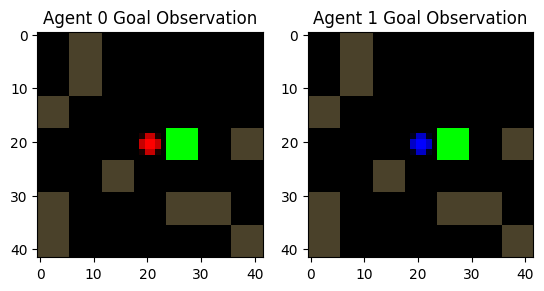

In [ ]:
# #| hide
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, cfg.env_cfg.num_agents)
# for i in range(cfg.env_cfg.num_agents):
#     ax[i].imshow(goal_obs[i])
#     ax[i].set_title(f"Agent {i} Goal Observation")
# plt.show()

In [ ]:
# goal_obs.shape

(2, 42, 42, 3)

In [ ]:
# #| hide
# from mawm.data.utils import base_tf, msg_tf
# def preprocessor(obs):
#     obs = torch.stack([base_tf(obs[i].astype(np.uint8)) for i in range(len(obs))])
#     return obs

In [ ]:
# #| hide
# from mawm.data.utils import base_tf, msg_tf
# goals = torch.stack([base_tf(goal_obs[i].astype(np.uint8)) for i in range(len(goal_obs))])
# goals.shape

torch.Size([2, 3, 42, 42])

In [ ]:
# #| hide 
# from mawm.models.jepa import JEPA
# from omegaconf import OmegaConf
# cfg = OmegaConf.load("../cfgs/MPCJepa/mpc.yaml")
# model = JEPA(cfg.model, input_dim=(3, 42, 42), action_dim=1)

In [ ]:
# #| hide
# import torch
# encoded_goals = model.backbone(goals)
# encoded_goals.shape

torch.Size([2, 16, 15, 15])

In [ ]:
# #| hide
# obs['agent_0'].keys()

dict_keys(['pov', 'selfpos', 'orientation', 'identity'])

In [ ]:
# #| hide
# obs = env.reset()
# goal_obs = np.array([
#     env.get_goal(env.agents[i], goal_pos)[0]
#     for i in range(config.env_cfg.num_agents)
# ])
# goals = torch.stack([base_tf(goal_obs[i].astype(np.uint8)) for i in range(len(goal_obs))])
# encoded_goals = model.backbone(goals)

# msgs = {agent: msg_tf((obs[agent]['pov'], agent, False)) for agent in agents}



In [ ]:
# #| hide
# obs['agent_0']['pov'].astype(np.uint8).shape,  msgs['agent_0'].shape

((42, 42, 3), torch.Size([5, 7, 7]))

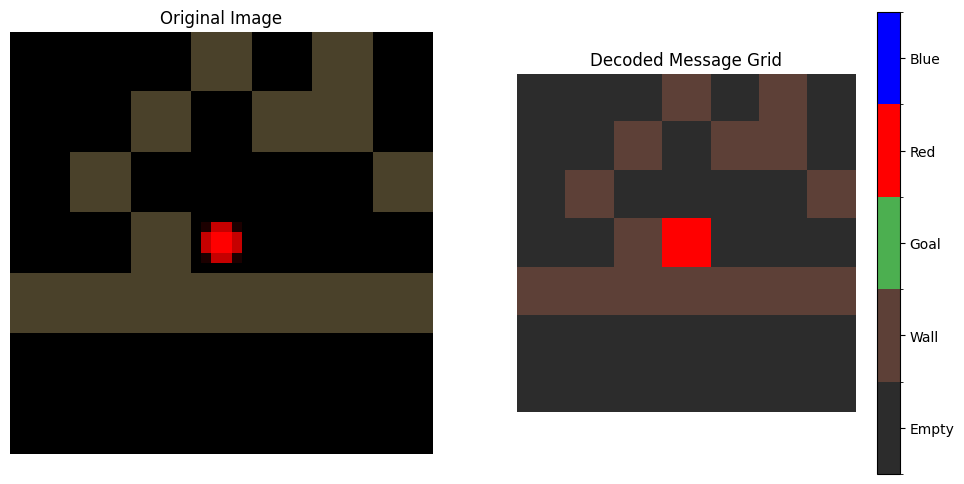

In [ ]:
# #| hide
# from mawm.data.utils import plot_grid
# plot_grid(obs['agent_0']['pov'].astype(np.uint8), msgs['agent_0'].permute(1, 2, 0))

In [ ]:
# #| hide
# obs_transformed = torch.stack([base_tf(obs[agent]['pov'].astype(np.uint8)) for agent in agents])
# encoded_obs = model.backbone(obs_transformed)
# encoded_obs.shape

torch.Size([2, 16, 15, 15])

In [ ]:
# #| hide
# pos = torch.stack([torch.from_numpy(obs[agent]['selfpos']) for agent in agents])
# pos.shape

torch.Size([2, 2])

In [ ]:
# #| hide
# encoded_obs = model.backbone(obs_transformed, position=pos)
# encoded_obs.shape

torch.Size([2, 18, 15, 15])

In [ ]:
# #| hide
# model.backbone.repr_dim

(18, 15, 15)

In [ ]:
# #| hide
# encoded_goals.shape

torch.Size([2, 16, 15, 15])

In [ ]:
# #| hide
# loss = torch.nn.functional.mse_loss(encoded_obs[:, :-2], encoded_goals)
# loss = loss.mean()
# loss


tensor(0.0622, grad_fn=<MeanBackward0>)

In [ ]:

# step = 0
# while step < 100:
#     msgs = {agent: msg_tf((obs[agent]['pov'], agent, False)) for agent in agents}
    
#     obs_transformed = torch.stack([base_tf(obs[agent]['pov'].astype(np.uint8)) for agent in agents])
#     pos = torch.stack([torch.from_numpy(obs[agent]['selfpos']) for agent in agents])
#     encoded_obs = model.backbone(obs_transformed, positions=pos)

#     actions = {agent: None for agent in agents}
#     for i, agent in enumerate(agents):
#         action = env.action_space.sample()
#         actions[agent] = action
    
#     obs, rewards, done, infos = env.step(actions)  # Execute FIRST
    
    
#     if done['__all__']:
#         break

#     step += 1
# env.close()

In [ ]:
# #| hide
# import nbdev
# nbdev.nbdev_export() # type: ignore  # noqa: E702
